# Week 2: Machine Learning Fundamentals

## Tutorial Outline

 1. Introduction to Scikit learn
   * The sklearn framework
   * Training and test splits
   * Normalization
 2. Model testing and hyper-parameter tuning
   * Train-test-split
   *  Cross-validation
   * GridSearchCV hyperparameter tuning

## Exercise (at the bottom of the notebook)
Using the Sklearn framework, fit 3 other types of regression models to the EnergyPlus data. Some options include:
* Ridge regression
* LARS LASSO
* Polynomial regression
* Support Vector Regression
* Decision Trees Regression 
* And more! See: https://scikit-learn.org/stable/supervised_learning.html

We will discuss these in more detail through the course (particularly with Nahid), so for now just focus on getting sklearn to work with them. You don't necessarily need to understand how they are working. 

I suggest going to the sklearn link above and referring to the documentation for whichever model you choose to fit. 

For all three, start with a train-test-split, calculating the scoring metric on the test set. Then, cross validation for the hyper parameter tuning for one of the poorly performing models to improve it.

### Optional
* Fit a Multi-output Regression.
* Apply PCA on the input features and build a linear regression with the principle componenets

## Scikit-learn Framework
For this tutorial and exercise, we're again going to work with the EnergyPlus dataset.

In [3]:
# Load data into pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('notebook')
sns.set_style('ticks')
np.random.seed()

# Load data
DATA_DIR = "data//"
df = pd.read_csv(DATA_DIR + "Week2_EnergyPlus_data.csv")
df = df.rename(columns={"ZONE ONE:Zone Thermal Comfort ASHRAE 55 Simple Model Summer or Winter Clothes Not Comfortable Time [hr](RunPeriod)": "ZONE ONE: Thermal Comfort"}) # Rename for convenience
# Note: I already know this is a clean dataset with no missing data.

print(df.shape)
df.head()

(300, 11)


,#,@@ORI@@,@@WINS@@,@@RSA@@,@@OVER@@,@@HS@@,@@LIGHTS@@,Electricity:Facility [J](RunPeriod),DistrictHeating:Facility [J](RunPeriod),DistrictCooling:Facility [J](RunPeriod),ZONE ONE: Thermal Comfort
0,0,78.163820,0.053802,0.418632,1.637014,17.195533,888.799227,9404491280,30747395742,178490805.8,6898.00
1,1,23.607704,0.064955,0.555359,0.132123,16.913773,958.359145,10140513118,29147949673,561839853.9,6807.00
2,2,85.610326,0.083691,0.649926,1.753641,19.757729,893.258468,9451675042,55906456798,264190321.3,6643.50
3,3,69.434576,0.050434,0.552010,0.276761,19.630274,1167.045742,12348651047,49637586712,504282183.7,6417.75
4,4,36.637364,0.069938,0.802213,1.631944,17.901530,976.628502,10333823375,37432515190,345733198.1,6845.00


## Models with Scikit-Learn

All models in sklearn follow a consistent API. This tutorial is closely adapted from the following by Jake VanderPlas: https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html I encourage everyone to refer to that for a more in depth discussion of each part of the API and for more great examples.


### the sklearn framework

Most commonly, the steps in using the sklearn estimator API are:

1. Choose a class of model by importing the appropriate estimator class from sklearn.
2. Choose model hyperparameters by instantiating this class with the desired values.
3. Arrange data into a features matrix and target vector. 
4. Fit the model to your data by calling the fit() method of the model instance. 
5. Apply the Model to new data:
    * For supervised learning, often we predict labels for unknown data using the `predict()` method.
    * For unsupervised learning, we often transform or infer properties of the data using the `transform()` or `predict()` method.

We'll first demonstrate this process by replicating the multiple linear regression we did last week in `statsmodels`.

#### 1. Choose a class of model

In sklearn, every class of model is represented by a Python class. 

In [4]:
from sklearn.linear_model import LinearRegression

#### 2. Choose model hyperparameters
Once we have decided on our model class, we need to create an instance of the model, with our chosen options. Depending on the model class we are working with, we might need to answer one or more questions like the following:

* Would we like to fit for the offset (i.e. y-intercept)? (In this case, yes)
* Would we like the model to be normalized?
* Would we like to preprocess our features to add model flexibility?
* What degree of regularization would we like to use in our model?
* How many model components would we like to use?

These are all choices which need to be made *once the model class is selected*. 

For our example, we can instantiate the `LinearRegression` class and specify that we would like to fit the intercept using the `fit_intercept`  hyperparameter.


In [5]:
model = LinearRegression(fit_intercept=True)
model

LinearRegression()

At this point, the only action is the storing of the hyperparameters, but we have not yet applied the model to any data. "the Scikit-Learn API makes very clear the distinction between *choice of model* and *application of model to data*.

#### 3. Arrange data inta a features matrix and target vector. 
sklearn does not deal directly with the full pandas Dataframe, instead we split it up based on what our ML task is. We will extract the features matrix and target array from the `DataFrame`. For the Boston dataset, `MV` (the median value) is our target feature, and everything else goes into our inputs.

The samples (i.e. rows) always refer to the individual objects described by the dataset. The features (i.e. columns) always refer to the distinct observations that describe each sample in a quantitative manner (this is a principle of tidy data, see [Hadley Wickham for more](https://vita.had.co.nz/papers/tidy-data.pdf))

For use in sklearn, we will extract the features matrix and target array from the `DataFrame`. For the Boston dataset, `MV` (the median value) is our target feature and, to replicate what we did last week, we'll use `LSTAT` and `RM` as the inputs.

In [6]:
# X = df.drop('MV', axis=1)
X = df[["@@ORI@@", "@@WINS@@", "@@RSA@@", "@@OVER@@", "@@HS@@", "@@LIGHTS@@"]]
y = df['DistrictHeating:Facility [J](RunPeriod)']
X.shape, y.shape

((300, 6), (300,))

To summarize, the expected layout of features and target values is visualised in the following diagram:

![title](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.02-samples-features.png)

#### 4. Fit the model to your data
Now it is time to apply our model to data. This can be done with the `fit()` method of the model.

In [7]:
model.fit(X, y)

LinearRegression()

The `fit()` command causes a number of model-dependent internal computations to take place, and the results of these computations are stored in model-specific attributes that the user can explore. In Scikit-learn, by convention, all model parameters that were learned during the `fit()` process have trailing underscores; For example, in this linear model, we have the following:

In [8]:
model.coef_

array([ 6.76724396e+05,  1.12972832e+11, -1.33656651e+09,  1.97349728e+08,
        8.91706300e+09, -4.08926860e+06])

In [9]:
model.intercept_

-125015314943.2562

These two parameters represent the slopes and intercept of the multiple linear fit to the data. Comparing to the model generated by `statsmodels` last week, we can see that these parameters are all the same as last weeks (which we would expect, since it's just an alternative package for fiting the same model). 

#### 5. Apply the Model to the data
Once the model is trained, the main task of supervised machine learning is to evaluate it based on what it says about new data that was not part of the training set. In Scikit-Learn, this can be done using the `predict()` method. For the purposes of demonstration at the moment, we'll just predict on the initial data. Typically, we should split the data into training and test sets, we'll go over this later.

In [10]:
yfit = model.predict(X)
print("R^2 score: ", model.score(X, y))

R^2 score:  0.9847591018190575


Finally, let's visualise the results by plotting the raw data and this model fit:

Text(0.5, 0, 'Predicted values')

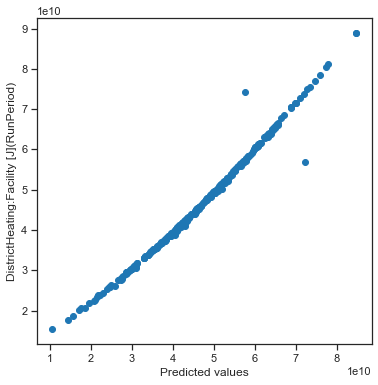

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.scatter(yfit, y)
ax.set_ylabel('DistrictHeating:Facility [J](RunPeriod)')
ax.set_xlabel("Predicted values")

### Normalization

Standardize features by removing the mean and scaling to unit variance

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
print(scaler.fit(df))


StandardScaler()


In [13]:
print(scaler.mean_)


[1.49500000e+02 4.50008252e+01 5.99936388e-02 5.99979983e-01
 1.10004645e+00 1.90022498e+01 9.99968039e+02 1.05807818e+10
 4.65630906e+10 3.58011252e+08 6.08350333e+03]


In [14]:
df_norm = df.copy()
df_norm[df_norm.columns] = scaler.transform(df)
df_norm

,#,@@ORI@@,@@WINS@@,@@RSA@@,@@OVER@@,@@HS@@,@@LIGHTS@@,Electricity:Facility [J](RunPeriod),DistrictHeating:Facility [J](RunPeriod),DistrictCooling:Facility [J](RunPeriod),ZONE ONE: Thermal Comfort
0,-1.726287,1.276292,-0.414338,-1.480467,0.929729,-1.207046,-1.088719,-1.088719,-1.177710,-1.639190,0.585279
1,-1.714740,-0.823323,0.332017,-0.364270,-1.675904,-1.395287,-0.407492,-0.407492,-1.296812,1.861146,0.519888
2,-1.703193,1.562873,1.585828,0.407747,1.131661,0.504727,-1.045048,-1.045048,0.695750,-0.856673,0.402401
3,-1.691646,0.940343,-0.639721,-0.391609,-1.425472,0.419576,1.636256,1.636256,0.228941,1.335591,0.240182
4,-1.680099,-0.321871,0.665498,1.650973,0.920951,-0.735378,-0.228573,-0.228573,-0.679905,-0.112110,0.547194
...,...,...,...,...,...,...,...,...,...,...,...
295,1.680099,-1.291850,-0.511445,-1.606234,-0.363322,1.043596,-1.629293,-1.629293,1.058827,-0.589663,-0.828522
296,1.691646,-0.620000,-0.389380,-1.189542,0.406577,0.483921,2.294132,2.294132,0.353818,-0.087824,0.229403
297,1.703193,1.235038,-0.836656,-1.868564,1.014857,-0.486845,0.105383,0.105383,-0.604480,-1.594844,0.546475
298,1.714740,0.917118,-0.334677,-0.370950,-1.536809,1.441374,0.434853,0.434853,1.413719,1.207310,-1.748480


In [15]:
model_2 = LinearRegression()

X = df_norm[["@@ORI@@", "@@WINS@@", "@@RSA@@", "@@OVER@@", "@@HS@@", "@@LIGHTS@@"]]
y = df_norm['DistrictHeating:Facility [J](RunPeriod)']

model_2.fit(X, y)
model_2.coef_

array([ 0.00130938,  0.12570758, -0.0121914 ,  0.00848747,  0.99388907,
       -0.03109301])

In [16]:
model.coef_

array([ 6.76724396e+05,  1.12972832e+11, -1.33656651e+09,  1.97349728e+08,
        8.91706300e+09, -4.08926860e+06])

Text(0.5, 0, 'Predicted values')

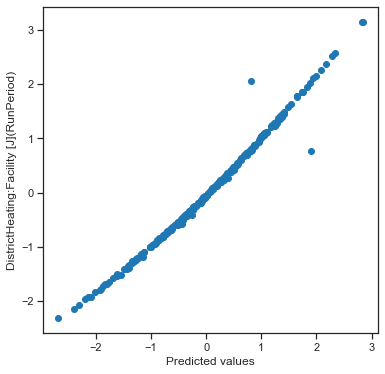

In [17]:
yfit = model_2.predict(X)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.scatter(yfit, y)
ax.set_ylabel('DistrictHeating:Facility [J](RunPeriod)')
ax.set_xlabel("Predicted values")

**We're going to use the normalized dataset throughout the rest of the tutorial and exercise.**

### Training and test splits
Resources: [sklearn documentation on cross-validation and model selection.](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

Particularly when we are focused on prediction (as opposed to inferential statistics) we would like to evaluate the model on data it has not seen before, so we will split the data into a *training set* and a *testing set*. This could be done by hand, but it is more convenient to use the `train_test_split` utility function.

In [18]:
from sklearn.model_selection import train_test_split

X = df_norm[["@@ORI@@", "@@WINS@@", "@@RSA@@", "@@OVER@@", "@@HS@@", "@@LIGHTS@@"]]
y = df_norm['DistrictHeating:Facility [J](RunPeriod)']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

print('Xtrain: ', Xtrain.shape)
print('ytrain: ', ytrain.shape)
print('Xtest: ', Xtest.shape)
print('ytest: ', ytest.shape)

Xtrain:  (210, 6)
ytrain:  (210,)
Xtest:  (90, 6)
ytest:  (90,)


The `test_size` variable sets what proportion of the dataset to include in the test split. In this case we've done a 70% train, 30% test split. `random_state` controls the random shuffling applied to the data before applying the split. We want to randomly sample the data splits, rather than e.g. just taking the first 70% for the training set. The `random_state` sets the random seed for reproducible output across multiple function calls.

Now, we `fit` the model to the training sets, and `predict` on the testing sets to evaluate the model.

In [19]:
model.fit(Xtrain, ytrain)
test_fit = model.predict(Xtest)

print("R^2: ", model.score(Xtest, ytest))

R^2:  0.9927841894272559


Text(0.5, 0, 'Predicted values')

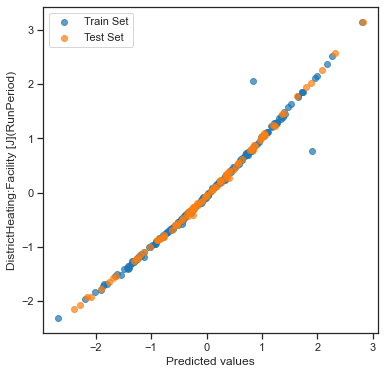

In [20]:
train_fit = model.predict(Xtrain)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.scatter(train_fit, ytrain, alpha=0.7, label='Train Set')
ax.scatter(test_fit, ytest, alpha=0.7, label='Test Set')
ax.legend()
ax.set_ylabel('DistrictHeating:Facility [J](RunPeriod)')
ax.set_xlabel("Predicted values")

By splitting into training and testing sets, we see how our model actually might perform on real-life new data. If we don't do this, we don't really know how good our model is at predicting, we only know how good it is at explaining the data we already have. 

### Cross-validation
I recommend going to the sklearn [documentation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) on cross-validation for a justification and in-depth explanation of k-fold cross validation

I also recommend this in depth tutorial from [Jason Brownlee](https://machinelearningmastery.com/k-fold-cross-validation/)) on Machine Learning Mastery

When fitting parameters or hyperparameters for estimators, there is a risk of overfitting *on the test set* because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can "leak" into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called 'validation set': training proceeds on the training set, after which evaluation is done on the validation set (and parameters can be tweaked), and when the experiment seems to be successful, final evaluation can be done on the test set. 

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

The solution to this is a procedure called cross-validation (CV). In the basic approach, called *k*-fold CV, the training set is split into *k* smaller sets. A model is trained using *k*-1 of the folds as training data, and tested on the remaining fold. This is then repeated *k* times such that each fold is used once as the testing set. This *k*-fold split is shown in the image below:

![title](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

The final performance of the CV model is then the average of the calculated performance metric for each fold test set. 

#### Cross validation with sklearn


In [21]:
from sklearn.model_selection import KFold
cv = KFold(3, True, random_state=4)  # k = 10 folds; shuffle=True prior to the split; seed random number generator with 42
for train, test in cv.split(df_norm):
    print(f"train index: {train}, test index: {test}")

train index: [  0   2   3   4   5   7   8   9  10  15  17  20  21  22  23  25  26  27
  28  29  30  31  32  34  35  36  37  38  40  41  44  49  50  51  52  53
  54  56  57  58  59  60  62  65  67  72  73  74  75  76  77  78  79  81
  85  86  87  89  90  94  95  96  97  98 102 104 105 107 108 109 110 114
 115 117 118 119 120 121 122 125 126 127 130 131 132 135 136 138 139 140
 141 143 144 145 146 148 149 150 151 156 158 159 161 162 164 165 167 168
 169 170 171 174 175 176 177 181 182 183 185 186 187 188 189 190 193 194
 195 196 197 198 199 201 204 205 206 207 208 209 210 214 215 217 219 221
 222 223 225 227 228 229 231 232 234 235 236 237 238 240 242 243 246 248
 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 265 266 267
 268 270 271 272 273 274 275 276 277 280 281 282 283 285 286 287 288 289
 290 298], test index: [  1   6  11  12  13  14  16  18  19  24  33  39  42  43  45  46  47  48
  55  61  63  64  66  68  69  70  71  80  82  83  84  88  91  92  93  99
 100 101 103 10

C:\Users\mitch\miniconda3\envs\GenDataSci\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Essentially, the train-test-split method is just a *k*=2 fold cross validation. This is one extreme, on the other extreme, we can set *k* = *n* (number of samples). This is called leave-one-out cross validation as, in this case, the test fold is just one sample point. The computational cost will increase with *k*. 

In [22]:
# X = df.drop('MV', axis=1)
X = df_norm[["@@ORI@@", "@@WINS@@", "@@RSA@@", "@@OVER@@", "@@HS@@", "@@LIGHTS@@"]]
y = df_norm['DistrictHeating:Facility [J](RunPeriod)']

scores = []
model = LinearRegression(fit_intercept=True)
cv = KFold(10, True, random_state=42)  # k = 10 folds; shuffle=True prior to the split; seed random number generator with 42

for train_index, test_index in cv.split(df_norm):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

print(scores)
print(np.mean(scores))

[0.9928454134412366, 0.9916250259820498, 0.99282272808096, 0.944206375418892, 0.9934673920596061, 0.9945238466882724, 0.9955537618894169, 0.9410883925778807, 0.9969744631826639, 0.990391355382642]
0.9833498754703619


### Parameter estimation tuning with cross validation grid search
See here for options on scoring: https://scikit-learn.org/stable/modules/model_evaluation.html

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Grid Search works pretty much just like any other estimator!
# Instantiate with its own hyperparameters
gsc = GridSearchCV(
    estimator=LinearRegression(),  # Define your estimator
    param_grid={                   # Create a grid of hyperparameter options to go through
        'fit_intercept': [True, False],
        'normalize': [True, False],
    },
    cv=5, scoring='r2', verbose=1, n_jobs=-1  # Define how many cross validations and what scoring metric to use
)

# Fit the grid search
grid_result = gsc.fit(X, y)

grid_result.cv_results_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


{'mean_fit_time': array([0.01800294, 0.01779947, 0.01419749, 0.00620708]),
 'std_fit_time': array([0.00178874, 0.00365439, 0.00172453, 0.00255673]),
 'mean_score_time': array([0.00360203, 0.00319929, 0.00280089, 0.00459371]),
 'std_score_time': array([0.00049108, 0.00040141, 0.00146572, 0.00279384]),
 'param_fit_intercept': masked_array(data=[True, True, False, False],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_normalize': masked_array(data=[True, False, True, False],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'fit_intercept': True, 'normalize': True},
  {'fit_intercept': True, 'normalize': False},
  {'fit_intercept': False, 'normalize': True},
  {'fit_intercept': False, 'normalize': False}],
 'split0_test_score': array([0.99526784, 0.99526784, 0.99531318, 0.99531318]),
 'split1_test_score': array([0.99601814, 0.99601814, 0.99614821, 0.99614821]),
 's

In [24]:
grid_result.best_score_

0.984536141973441

Best params:  {'fit_intercept': False, 'normalize': True}
R^2:  0.9847591018190575


Text(0.5, 0, 'Predicted values')

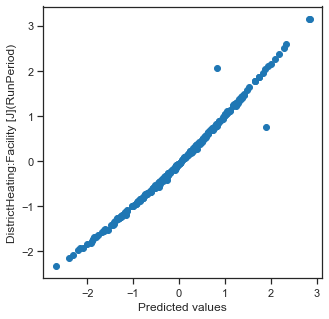

In [25]:

# Extract the identified best parameters from the options you gave
best_params = grid_result.best_params_

# Instantiate the final model using the best hyperparameters
best_model = LinearRegression(
    fit_intercept=best_params['fit_intercept'],
    normalize=best_params['normalize']
)

# Fit the model
best_model.fit(X, y)

# Predict on the data to look at how it did
model_fit = best_model.predict(X)

print("Best params: ", best_params)
print("R^2: ", best_model.score(X, y))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(model_fit, y)
ax.set_ylabel('DistrictHeating:Facility [J](RunPeriod)')
ax.set_xlabel("Predicted values")


## Exercise
Using the Sklearn framework, fit 3 other types of regression models to the EnergyPlus data. 

    1. The first to fit is a Support Vector Regression. Use a 'linear' kernel, and leave the rest of the hyperparameters to their default. Nahid will cover SVR hyperparameters next week. Make sure to normalise the data first and use a train-test-split.
    2a. Fit a Decision Tree Regression. Start with a train-test-split, with a depth of 2. 
    2b. Use GridSearchCV to test different tree depths, then fit the best performing depth.
    3. Fit a regression model of your choice.

Some options include:
* Ridge regression
* LARS LASSO
* Polynomial regression
* Support Vector Regression
* Decision Trees Regression 
* And more! See: https://scikit-learn.org/stable/supervised_learning.html

We will discuss these algorithms in more detail through the course (particularly with Nahid), so for now just focus on getting sklearn to work with them. You don't necessarily need to understand how they are working. 

I suggest going to the sklearn link above and referring to the documentation for each model as you fit it.

### Optional
Fit a Multi-output Regression

## Solution


In [26]:
# Split normalized dataset into X and y
# X = 
# y = 

# Create the training and testing splits
# Xtrain, Xtest, ytrain, ytest = train_test_split()


### Regression Algorithm 1 - DecisionTreeRegression

1. Choose a class of model by importing the appropriate estimator class from sklearn.
2. Choose model hyperparameters by instantiating this class with the desired values.
3. Arrange data into a features matrix and target vector. 
4. Fit the model to your data by calling the fit() method of the model instance. 
5. Apply the Model to new data:
    * For supervised learning, often we predict labels for unknown data using the `predict()` method.

In [27]:
# Step 1: import the estimator function from sklearn

# Step 2: Instantiate class with hyperparameters

# Step 3: Already done above!
# Step 4: Fit the model (to training data)

# model = estimator.fit(Xtrain, ytrain)

# Step 5: Apply to new data to predict

# See how it did!
print("R^2: ", model.score(Xtest, ytest))

# Plot the comparison plot

R^2:  0.9931058345273485


**Hyperparameter Tuning**

In [28]:
from sklearn.model_selection import GridSearchCV

# Instantiate GridSearchCV with the list of parameters
gsc = GridSearchCV(
    estimator= ,
    param_grid={
        
    },
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1
)

# Fit the grid search

# Extract the identified best parameters from the options you gave
best_params = gsc.best_params_

# Instantiate the final model using the best hyperparameters

# Fit the model

# Predict on the data to look at how it did


SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-28-0bccd296f021>, line 5)

### Regression Algorithm 2 - Support Vector Regression


In [29]:
# Step 1: import the estimator function from sklearn

# Step 2: Instantiate class with hyperparameters

# Step 3: Already done above!
# Step 4: Fit the model (to training data)

# model = estimator.fit(Xtrain, ytrain)

# Step 5: Apply to new data to predict

# See how it did!
print("R^2: ", model.score(Xtest, ytest))

# Plot the comparison plot

R^2:  0.9931058345273485


### Regression Algorithm 3

In [30]:
# Step 1: import the estimator function from sklearn

# Step 2: Instantiate class with hyperparameters

# Step 3: Already done above!
# Step 4: Fit the model (to training data)

# model = estimator.fit(Xtrain, ytrain)

# Step 5: Apply to new data to predict

# See how it did!
print("R^2: ", model.score(Xtest, ytest))

# Plot the comparison plot

R^2:  0.9931058345273485


## Optional - Multi-output Decision Tree Regressor

In [31]:
y = df_norm[["DistrictHeating:Facility [J](RunPeriod)", "ZONE ONE: Thermal Comfort"]]

# Instantiate GridSearchCV with the list of parameters

# Fit the grid search

# Extract the identified best parameters from the options you gave

# Instantiate the final model using the best hyperparameters

# Fit the model

# Predict on the data to look at how it did
